<a href="https://colab.research.google.com/github/muratgguzel/AIML-DeepLearnig-Introduction-Neural-Networks/blob/main/High_Code_Plant_Seedling_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to Computer Vision: Plant Seedlings Classification

## Problem Statement

### Context

In recent times, the field of agriculture has been in urgent need of modernizing, since the amount of manual work people need to put in to check if plants are growing correctly is still highly extensive. Despite several advances in agricultural technology, people working in the agricultural industry still need to have the ability to sort and recognize different plants and weeds, which takes a lot of time and effort in the long term. The potential is ripe for this trillion-dollar industry to be greatly impacted by technological innovations that cut down on the requirement for manual labor, and this is where Artificial Intelligence can actually benefit the workers in this field, as **the time and energy required to identify plant seedlings will be greatly shortened by the use of AI and Deep Learning.** The ability to do so far more efficiently and even more effectively than experienced manual labor, could lead to better crop yields, the freeing up of human inolvement for higher-order agricultural decision making, and in the long term will result in more sustainable environmental practices in agriculture as well.


### Objective

The aim of this project is to Build a Convolutional Neural Netowrk to classify plant seedlings into their respective categories.

### Data Dictionary

The Aarhus University Signal Processing group, in collaboration with the University of Southern Denmark, has recently released a dataset containing **images of unique plants belonging to 12 different species.**

- The dataset can be download from Olympus.
- The data file names are:
    - images.npy
    - Label.csv
- Due to the large volume of data, the images were converted to the images.npy file and the labels are also put into Labels.csv, so that you can work on the data/project seamlessly without having to worry about the high data volume.

- The goal of the project is to create a classifier capable of determining a plant's species from an image.

**List of Species**

- Black-grass
- Charlock
- Cleavers
- Common Chickweed
- Common Wheat
- Fat Hen
- Loose Silky-bent
- Maize
- Scentless Mayweed
- Shepherds Purse
- Small-flowered Cranesbill
- Sugar beet

####**Note: Please use GPU runtime to execute the code efficiently**

## Importing necessary libraries

In [332]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

Mon Jul 17 18:55:27 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    41W / 300W |   5164MiB / 16384MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [333]:
if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')
! pwd

You are using a high-RAM runtime!
/content


In [334]:
#%%shell
#jupyter nbconvert --to html ///content/Murat_Goksenin_Guzel_Project7_v2_1.ipynb

In [335]:
import os
import numpy as np                                                                               # Importing numpy for Matrix Operations
import pandas as pd                                                                              # Importing pandas to read CSV files
import matplotlib.pyplot as plt                                                                  # Importting matplotlib for Plotting and visualizing images
import math                                                                                      # Importing math module to perform mathematical operations
import cv2                                                                                       # Importing openCV for image processing
import seaborn as sns                                                                            # Importing seaborn to plot graphs


# Tensorflow modules
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator                              # Importing the ImageDataGenerator for data augmentation
from tensorflow.keras.models import Sequential                                                   # Importing the sequential module to define a sequential model
from tensorflow.keras.layers import Dense,Dropout,Flatten,Conv2D,MaxPooling2D,BatchNormalization # Defining all the layers to build our CNN Model
from tensorflow.keras.optimizers import Adam,SGD                                                 # Importing the optimizers which can be used in our model
from sklearn import preprocessing                                                                # Importing the preprocessing module to preprocess the data
from sklearn.model_selection import train_test_split                                             # Importing train_test_split function to split the data into train and test
from sklearn.metrics import confusion_matrix                                                     # Importing confusion_matrix to plot the confusion matrix

# Display images using OpenCV
from google.colab.patches import cv2_imshow                                                      # Importing cv2_imshow from google.patches to display images


from tensorflow.keras.models import Model
from keras.applications.vgg16 import VGG16

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

## Loading the dataset

In [336]:
# Mount Google drive to access the dataset
# Run the below code if you using google colab
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [387]:
# Load the image file of the dataset
images = np.load('/content/drive/MyDrive/RootCSV/images.npy')

In [388]:


# Load the labels file of the dataset
labels = pd.read_csv('/content/drive/MyDrive/RootCSV/Labels.csv')

## Data Overview

### Understand the shape of the dataset

In [389]:
print(images.shape)
print(labels.shape)

(4750, 128, 128, 3)
(4750, 1)


There are 4750 RGB images of shape 128 x 128 X 3, each image having 3 channels.

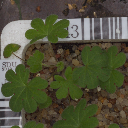

In [390]:
cv2_imshow(images[3])

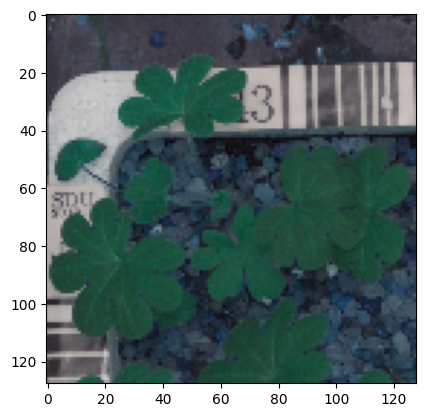

In [391]:
plt.imshow(images[3])

In [392]:
# Converting the images from BGR to RGB using cvtColor function of OpenCV
for i in range(len(images)):
  images[i] = cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB)

## Exploratory Data Analysis

- EDA is an important part of any project involving data.
- It is important to investigate and understand the data better before building a model with it.
- A few questions have been mentioned below which will help you understand the data better.
- A thorough analysis of the data, in addition to the questions mentioned below, should be done.

1. How are these different category plant images different from each other?
2. Is the dataset provided an imbalance? (Check with using bar plots)

In [393]:
def plot_images(images,labels):
  num_classes=12                                                                  # Number of Classes
  categories=np.unique(labels)
  keys=dict(labels['Label'])                                                      # Obtaing the unique classes from y_train
  rows = 3                                                                        # Defining number of rows=3
  cols = 4                                                                        # Defining number of columns=4
  fig = plt.figure(figsize=(10, 8))                                               # Defining the figure size to 10x8
  for i in range(cols):
      for j in range(rows):
          random_index = np.random.randint(0, len(labels))                        # Generating random indices from the data and plotting the images
          ax = fig.add_subplot(rows, cols, i * rows + j + 1)                      # Adding subplots with 3 rows and 4 columns
          ax.imshow(images[random_index, :])                                      # Plotting the image
          ax.set_title(keys[random_index])
  plt.show()

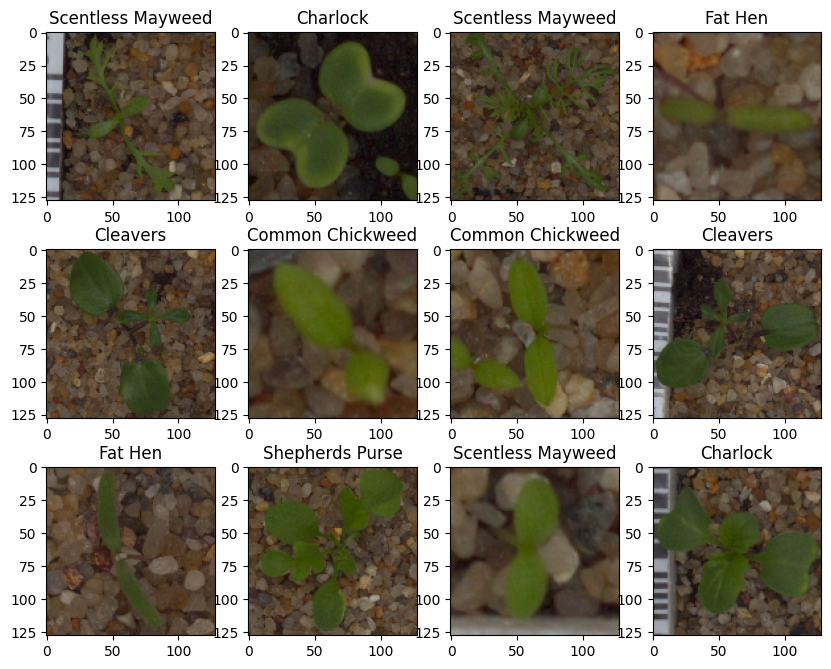

In [394]:
plot_images(images,labels)

In [395]:
labels['Label']

0       Small-flowered Cranesbill
1       Small-flowered Cranesbill
2       Small-flowered Cranesbill
3       Small-flowered Cranesbill
4       Small-flowered Cranesbill
                  ...            
4745             Loose Silky-bent
4746             Loose Silky-bent
4747             Loose Silky-bent
4748             Loose Silky-bent
4749             Loose Silky-bent
Name: Label, Length: 4750, dtype: object

In [396]:
labels = labels.replace(r'^\s*$', np.nan, regex=True)

In [397]:
labels['Label']=labels['Label'].str.replace(' ', '_')

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
 [Text(0, 0, 'Small-flowered_Cranesbill'),
  Text(1, 0, 'Fat_Hen'),
  Text(2, 0, 'Shepherds_Purse'),
  Text(3, 0, 'Common_wheat'),
  Text(4, 0, 'Common_Chickweed'),
  Text(5, 0, 'Charlock'),
  Text(6, 0, 'Cleavers'),
  Text(7, 0, 'Scentless_Mayweed'),
  Text(8, 0, 'Sugar_beet'),
  Text(9, 0, 'Maize'),
  Text(10, 0, 'Black-grass'),
  Text(11, 0, 'Loose_Silky-bent')])

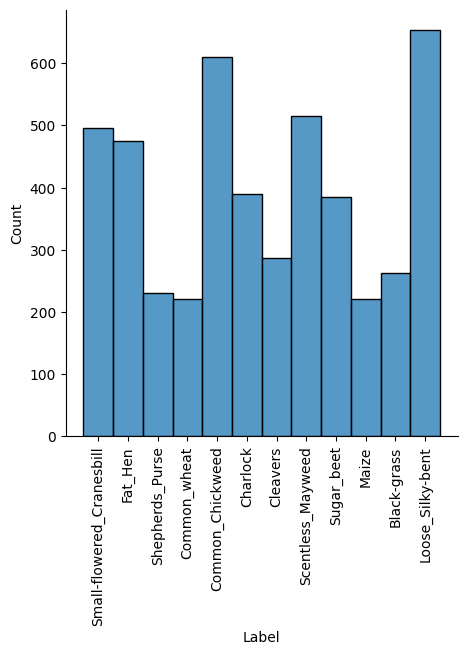

In [398]:
sns.displot(labels, x='Label')
plt.xticks(rotation='vertical')

## Data Pre-Processing

### Convert the BGR images to RGB images.

In [399]:
# Converting the images from BGR to RGB using cvtColor function of OpenCV
for i in range(len(images)):
  images[i] = cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB)

### Resize the images

As the size of the images is large, it may be computationally expensive to train on these larger images; therefore, it is preferable to reduce the image size from 128 to 64.

In [402]:
images_decreased=[]
height = 64
width = 64
dimensions = (width, height)
for i in range(len(images)):
  images_decreased.append( cv2.resize(images[i], dimensions, interpolation=cv2.INTER_LINEAR))

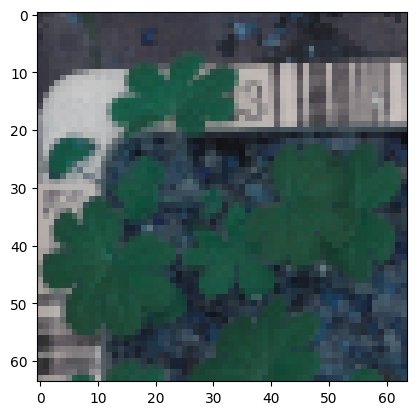

In [401]:
plt.imshow(images_decreased[3])

### Data Preparation for Modeling

- Before you proceed to build a model, you need to split the data into train, test, and validation to be able to evaluate the model that you build on the train data
- You'll have to encode categorical features and scale the pixel values.
- You will build a model using the train data and then check its performance

**Split the dataset**

In [352]:
from sklearn.model_selection import train_test_split
X_temp, X_test, y_temp, y_test = train_test_split(np.array(images_decreased),labels , test_size=0.1, random_state=42,stratify=labels)
X_train, X_val, y_train, y_val = train_test_split(X_temp,y_temp , test_size=0.1, random_state=42,stratify=y_temp)

In [353]:
print(X_train.shape,y_train.shape)
print(X_val.shape,y_val.shape)
print(X_test.shape,y_test.shape)

(3847, 64, 64, 3) (3847, 1)
(428, 64, 64, 3) (428, 1)
(475, 64, 64, 3) (475, 1)


### Encode the target labels

In [354]:
# Convert labels from names to one hot vectors.
# We have already used encoding methods like onehotencoder and labelencoder earlier so now we will be using a new encoding method called labelBinarizer.
# Labelbinarizer works similar to onehotencoder

from sklearn.preprocessing import LabelBinarizer
enc = LabelBinarizer()
y_train_encoded = enc.fit_transform(y_train)
y_val_encoded=enc.transform(y_val)
y_test_encoded=enc.transform(y_test)

### Data Normalization

In [355]:
# Normalizing the image pixels
X_train_normalized = X_train.astype('float32')/255.0
X_val_normalized = X_val.astype('float32')/255.0
X_test_normalized = X_test.astype('float32')/255.0

## Model Building

In [356]:
# Clearing backend
from tensorflow.keras import backend
backend.clear_session()

In [357]:
# Fixing the seed for random number generators
import random
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

CNN Model with the following 2 main parts -

The Feature Extraction layers which are comprised of convolutional and pooling layers.
The Fully Connected classification layers for prediction

In [358]:
# Intializing a sequential model
model = Sequential()

# Adding first conv layer with 64 filters and kernel size 3x3 , padding 'same' provides the output size same as the input size
# Input_shape denotes input image dimension of images
model.add(Conv2D(64, (3, 3), activation='relu', padding="same", input_shape=(64, 64, 3)))

# Adding max pooling to reduce the size of output of first conv layer
model.add(MaxPooling2D((2, 2), padding = 'same'))

model.add(Conv2D(32, (3, 3), activation='relu', padding="same"))
model.add(MaxPooling2D((2, 2), padding = 'same'))

# flattening the output of the conv layer after max pooling to make it ready for creating dense connections
model.add(Flatten())

# Adding a fully connected dense layer with 100 neurons
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.3))
# Adding the output layer with 10 neurons and activation functions as softmax since this is a multi-class classification problem
model.add(Dense(12, activation='softmax'))

# Using SGD Optimizer
# opt = SGD(learning_rate=0.01, momentum=0.9)
opt=Adam()
# Compile model
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Generating the summary of the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        18464     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 16)                1

In [359]:
history_1 = model.fit(
            X_train_normalized, y_train_encoded,
            epochs=30,
            validation_data=(X_val_normalized,y_val_encoded),
            batch_size=32,
            verbose=2
)

Epoch 1/30
121/121 - 2s - loss: 2.4158 - accuracy: 0.1588 - val_loss: 2.3404 - val_accuracy: 0.2290 - 2s/epoch - 18ms/step
Epoch 2/30
121/121 - 0s - loss: 2.2154 - accuracy: 0.2495 - val_loss: 2.0370 - val_accuracy: 0.3528 - 493ms/epoch - 4ms/step
Epoch 3/30
121/121 - 0s - loss: 2.0494 - accuracy: 0.2813 - val_loss: 1.8976 - val_accuracy: 0.3481 - 474ms/epoch - 4ms/step
Epoch 4/30
121/121 - 0s - loss: 1.9504 - accuracy: 0.2943 - val_loss: 1.7693 - val_accuracy: 0.3785 - 474ms/epoch - 4ms/step
Epoch 5/30
121/121 - 0s - loss: 1.8841 - accuracy: 0.3083 - val_loss: 1.6798 - val_accuracy: 0.4089 - 475ms/epoch - 4ms/step
Epoch 6/30
121/121 - 0s - loss: 1.8530 - accuracy: 0.3273 - val_loss: 1.6277 - val_accuracy: 0.4206 - 487ms/epoch - 4ms/step
Epoch 7/30
121/121 - 0s - loss: 1.8230 - accuracy: 0.3356 - val_loss: 1.5942 - val_accuracy: 0.4836 - 480ms/epoch - 4ms/step
Epoch 8/30
121/121 - 0s - loss: 1.7632 - accuracy: 0.3585 - val_loss: 1.5556 - val_accuracy: 0.4836 - 476ms/epoch - 4ms/step
Ep

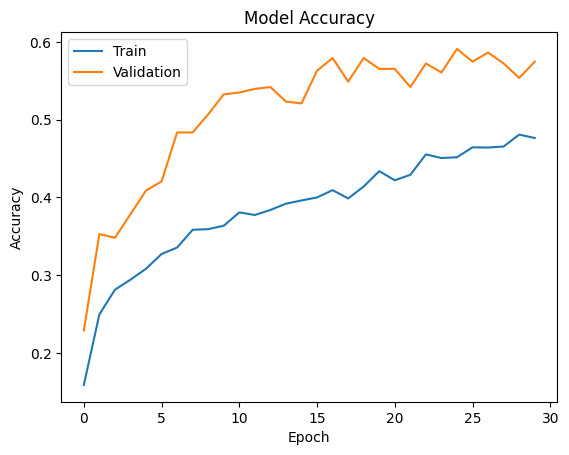

In [360]:
plt.plot(history_1.history['accuracy'])
plt.plot(history_1.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [361]:
accuracy = model.evaluate(X_test_normalized, y_test_encoded, verbose=2)

15/15 - 0s - loss: 1.3680 - accuracy: 0.5263 - 56ms/epoch - 4ms/step


### **Generating the predictions using test data**

In [362]:
# Here we would get the output as probablities for each category
y_pred=model.predict(X_test_normalized)

15/15 [==============================] - 0s 2ms/step


In [363]:
y_pred

array([[3.18310178e-08, 1.15226112e-05, 1.30359268e-07, ...,
        1.01622626e-01, 3.64183070e-04, 3.97590809e-02],
       [2.52016453e-05, 3.90343950e-03, 3.81649262e-03, ...,
        1.46385971e-02, 9.10477221e-01, 6.41127080e-02],
       [4.53073917e-05, 2.91907956e-04, 1.25564879e-03, ...,
        3.41737154e-03, 9.16014314e-01, 7.66622126e-02],
       ...,
       [2.70947278e-01, 4.35071179e-09, 2.72088369e-06, ...,
        4.37631398e-12, 7.16449903e-12, 5.10398168e-05],
       [2.49795179e-04, 2.66637187e-03, 8.18668574e-04, ...,
        8.64135921e-02, 7.03578908e-03, 9.66224670e-02],
       [9.92847420e-03, 5.62226996e-02, 1.22324996e-01, ...,
        7.41235465e-02, 3.43879372e-01, 2.43890941e-01]], dtype=float32)

### **Plotting the Confusion Matrix**

The Confusion matrix is also defined as an inbuilt function in the TensorFlow module, so we can use that for evaluating the classification model.

The Confusion matrix expects categorical data as input. However, y_test_encoded is an encoded value, whereas y_pred has probabilities. So,we must retrieve the categorical values from the encoded values.

We will use the argmax() function to obtain the maximum value over each category on both y_test_encoded and y_pred and obtain their respective classes.

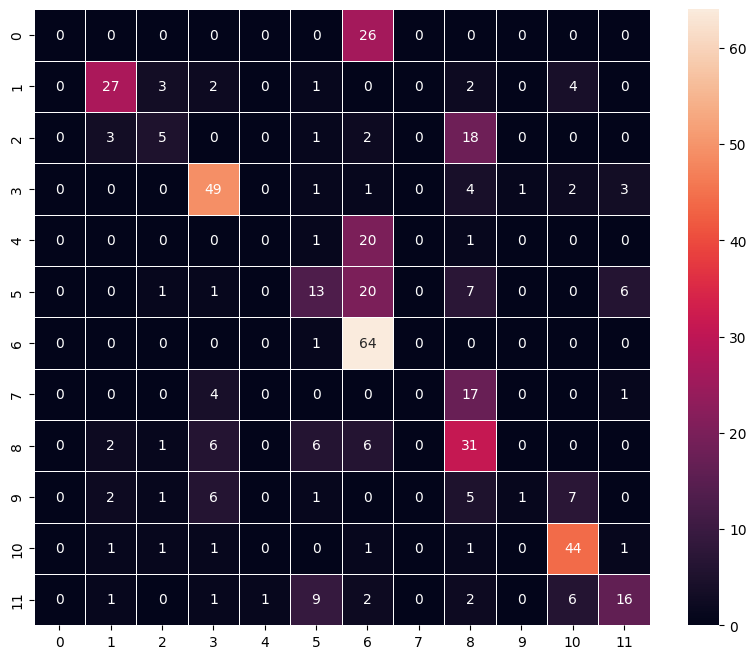

In [364]:
# Obtaining the categorical values from y_test_encoded and y_pred
y_pred_arg=np.argmax(y_pred,axis=1)
y_test_arg=np.argmax(y_test_encoded,axis=1)

# Plotting the Confusion Matrix using confusion matrix() function which is also predefined tensorflow module
confusion_matrix = tf.math.confusion_matrix(y_test_arg,y_pred_arg)
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(
    confusion_matrix,
    annot=True,
    linewidths=.4,
    fmt="d",
    square=True,
    ax=ax
)
plt.show()

<b> Observations</b><br>
- We observe that some of the classes are not predicted correctly.
- In comparison to the rest, we can see that classes 0,3, and 4 are well classified.
- We can also observe that classes 1,2,5,7 and 9 are mostly misclassified.

## Model Performance Improvement

**Reducing the Learning Rate:**

**Hint**: Use **ReduceLRonPlateau()** function that will be used to decrease the learning rate by some factor, if the loss is not decreasing for some time. This may start decreasing the loss at a smaller learning rate. There is a possibility that the loss may still not decrease. This may lead to executing the learning rate reduction again in an attempt to achieve a lower loss.

### **Data Augmentation**

Data Augmentation
In most of the real-world case studies, it is challenging to acquire a large number of images and then train CNNs. To overcome this problem, one approach we might consider is Data Augmentation. CNNs have the property of translational invariance, which means they can recognise an object even if its appearance shifts translationally in some way.
Taking this attribute into account, we can augment the images using the techniques listed below -
1. Horizontal Flip (should be set to True/False)
2. Vertical Flip (should be set to True/False)
3. Height Shift (should be between 0 and 1)
4. Width Shift (should be between 0 and 1)
5. Rotation (should be between 0 and 180)
6. Shear (should be between 0 and 1)
7. Zoom (should be between 0 and 1) etc.



In [385]:
# All images to be rescaled by 1/255.
train_datagen = ImageDataGenerator(
                              rotation_range=20,
                              fill_mode='nearest'
                              )

In [366]:
# Intializing a sequential model
model = Sequential()

# Adding first conv layer with 64 filters and kernel size 3x3 , padding 'same' provides the output size same as the input size
# Input_shape denotes input image dimension images
model.add(Conv2D(64, (3, 3), activation='relu', padding="same", input_shape=(64, 64, 3)))

# Adding max pooling to reduce the size of output of first conv layer
model.add(MaxPooling2D((2, 2), padding = 'same'))
# model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu', padding="same"))
model.add(MaxPooling2D((2, 2), padding = 'same'))
model.add(BatchNormalization())
# flattening the output of the conv layer after max pooling to make it ready for creating dense connections
model.add(Flatten())

# Adding a fully connected dense layer with 100 neurons
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.3))
# Adding the output layer with 10 neurons and activation functions as softmax since this is a multi-class classification problem
model.add(Dense(12, activation='softmax'))

# Using SGD Optimizer
# opt = SGD(learning_rate=0.01, momentum=0.9)
opt=Adam()
# Compile model
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Generating the summary of the model
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 64, 64, 64)        1792      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 32, 32, 64)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 32, 32, 32)        18464     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 batch_normalization (BatchN  (None, 16, 16, 32)       128       
 ormalization)                                                   
                                                      

In [367]:
# Epochs
epochs = 25
# Batch size
batch_size = 64

history = model.fit(train_datagen.flow(X_train_normalized,y_train_encoded,
                                       batch_size=batch_size,
                                       seed=42,
                                       shuffle=False),
                    epochs=epochs,
                    steps_per_epoch=X_train_normalized.shape[0] // batch_size,
                    validation_data=(X_val_normalized,y_val_encoded),
                    verbose=1)

Epoch 1/25
60/60 [==============================] - 7s 81ms/step - loss: 2.2701 - accuracy: 0.2078 - val_loss: 2.4372 - val_accuracy: 0.1846
Epoch 2/25
60/60 [==============================] - 4s 67ms/step - loss: 1.8438 - accuracy: 0.3529 - val_loss: 2.3597 - val_accuracy: 0.2336
Epoch 3/25
60/60 [==============================] - 4s 66ms/step - loss: 1.6055 - accuracy: 0.4425 - val_loss: 2.2997 - val_accuracy: 0.2079
Epoch 4/25
60/60 [==============================] - 4s 67ms/step - loss: 1.4586 - accuracy: 0.4914 - val_loss: 2.1576 - val_accuracy: 0.3107
Epoch 5/25
60/60 [==============================] - 4s 61ms/step - loss: 1.3615 - accuracy: 0.5189 - val_loss: 1.9561 - val_accuracy: 0.4603
Epoch 6/25
60/60 [==============================] - 4s 62ms/step - loss: 1.3267 - accuracy: 0.5197 - val_loss: 1.8399 - val_accuracy: 0.3995
Epoch 7/25
60/60 [==============================] - 4s 66ms/step - loss: 1.2254 - accuracy: 0.5575 - val_loss: 1.4595 - val_accuracy: 0.6051
Epoch 8/25
60

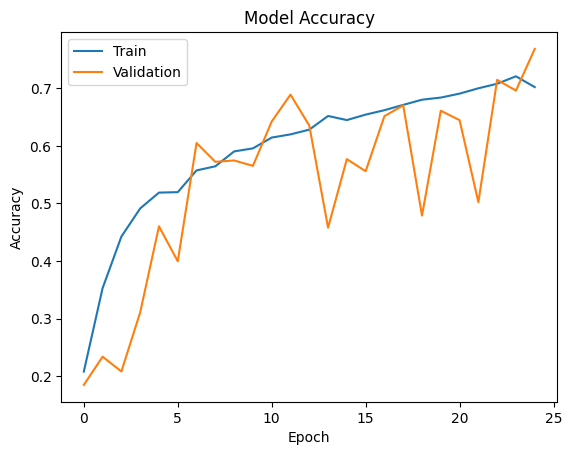

In [368]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [369]:
accuracy = model.evaluate(X_test_normalized, y_test_encoded, verbose=2)

15/15 - 0s - loss: 0.7666 - accuracy: 0.7874 - 56ms/epoch - 4ms/step


We can observe that our accuracy has improved compared to our previous model.

In [370]:
# Here we would get the output as probablities for each category
y_pred=model.predict(X_test_normalized)

15/15 [==============================] - 0s 2ms/step


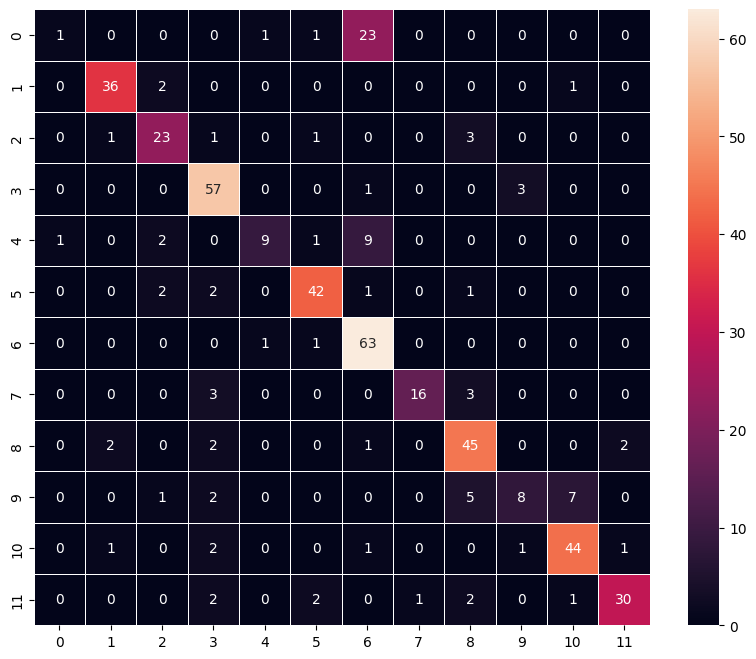

In [371]:
# Obtaining the categorical values from y_test_encoded and y_pred
y_pred_arg=np.argmax(y_pred,axis=1)
y_test_arg=np.argmax(y_test_encoded,axis=1)

# Plotting the Confusion Matrix using confusion matrix() function which is also predefined tensorflow module
confusion_matrix = tf.math.confusion_matrix(y_test_arg,y_pred_arg)
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(
    confusion_matrix,
    annot=True,
    linewidths=.4,
    fmt="d",
    square=True,
    ax=ax
)
plt.show()

Observation:

The confusion matrix appears to be improving as well, however there is still some confusion with the 3,5,7 classes of monkey species.

The 5th class is the most confused class among all.

We can observe that this model has outperformed our previous model.

## Transfer Learning

I will be using  Transfer Learning for model improvement.

We will be loading a pre-built architecture - VGG16, which was trained on the ImageNet dataset and is the runner-up in the ImageNet competition in 2014.

For training VGG16, we will directly use the convolutional and pooling layers and freeze their weights i.e. no training will be done on them.

For classification, we will replace the existing fully-connected layers with FC layers created specifically for our problem

In [421]:
images_increased=[]
height = 224
width = 224
dimensions = (width, height)
for i in range(len(images)):
  images_increased.append( cv2.resize(images[i], dimensions, interpolation=cv2.INTER_LINEAR))

In [422]:
from sklearn.model_selection import train_test_split
X_temp, X_test, y_temp, y_test = train_test_split(np.array(images_increased),labels , test_size=0.1, random_state=42,stratify=labels)
X_train, X_val, y_train, y_val = train_test_split(X_temp,y_temp , test_size=0.1, random_state=42,stratify=y_temp)

In [423]:
print(X_train.shape,y_train.shape)
print(X_val.shape,y_val.shape)
print(X_test.shape,y_test.shape)

(3847, 224, 224, 3) (3847, 1)
(428, 224, 224, 3) (428, 1)
(475, 224, 224, 3) (475, 1)


In [424]:
# Convert labels from names to one hot vectors.
# We have already used encoding methods like onehotencoder and labelencoder earlier so now we will be using a new encoding method called labelBinarizer.
# Labelbinarizer works similar to onehotencoder

from sklearn.preprocessing import LabelBinarizer
enc = LabelBinarizer()
y_train_encoded = enc.fit_transform(y_train)
y_val_encoded=enc.transform(y_val)
y_test_encoded=enc.transform(y_test)

In [425]:
# Normalizing the image pixels
X_train_normalized = X_train.astype('float32')/255.0
X_val_normalized = X_val.astype('float32')/255.0
X_test_normalized = X_test.astype('float32')/255.0

In [426]:
# Summary of the whole model
model = VGG16(weights='imagenet')
model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [427]:
vgg_model = VGG16(weights='imagenet', include_top = False, input_shape = (224,224,3))
vgg_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [428]:
# Getting only the conv layers for transfer learning.
transfer_layer = model.get_layer('block5_pool')
vgg_model = Model(inputs=model.input, outputs=transfer_layer.output)

In [429]:
vgg_model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [430]:
# Making all the layers of the VGG model non-trainable. i.e. freezing them
for layer in vgg_model.layers:
    layer.trainable = False

In [431]:
for layer in vgg_model.layers:
    print(layer.name, layer.trainable)

input_4 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 False
block5_conv2 False
block5_conv3 False
block5_pool False


In [432]:
new_model = Sequential()

# Adding the convolutional part of the VGG16 model from above
new_model.add(vgg_model)

# Flattening the output of the VGG16 model because it is from a convolutional layer
new_model.add(Flatten())

# Adding a dense output layer
new_model.add(Dense(32, activation='relu'))
new_model.add(Dropout(0.2))
new_model.add(Dense(16, activation='relu'))
new_model.add(Dense(12, activation='softmax'))
opt=Adam()
# Compile model
new_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Generating the summary of the model
new_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_4 (Functional)        (None, 7, 7, 512)         14714688  
                                                                 
 flatten_3 (Flatten)         (None, 25088)             0         
                                                                 
 dense_7 (Dense)             (None, 32)                802848    
                                                                 
 dropout_3 (Dropout)         (None, 32)                0         
                                                                 
 dense_8 (Dense)             (None, 16)                528       
                                                                 
 dense_9 (Dense)             (None, 12)                204       
                                                                 
Total params: 15,518,268
Trainable params: 803,580
Non

In [433]:
new_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
new_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_4 (Functional)        (None, 7, 7, 512)         14714688  
                                                                 
 flatten_3 (Flatten)         (None, 25088)             0         
                                                                 
 dense_7 (Dense)             (None, 32)                802848    
                                                                 
 dropout_3 (Dropout)         (None, 32)                0         
                                                                 
 dense_8 (Dense)             (None, 16)                528       
                                                                 
 dense_9 (Dense)             (None, 12)                204       
                                                                 
Total params: 15,518,268
Trainable params: 803,580
Non

In [434]:
# Epochs
epochs = 10
# Batch size
batch_size = 64

history = new_model.fit(train_datagen.flow(X_train_normalized,y_train_encoded,
                                       batch_size=batch_size,
                                       seed=42,
                                       shuffle=False),
                    epochs=epochs,
                    steps_per_epoch=X_train_normalized.shape[0] // batch_size,
                    validation_data=(X_val_normalized,y_val_encoded),
                    verbose=1)

Epoch 1/10
60/60 [==============================] - 40s 625ms/step - loss: 0.6052 - accuracy: 0.0819 - val_loss: 0.4794 - val_accuracy: 0.0818
Epoch 2/10
60/60 [==============================] - 37s 617ms/step - loss: 0.4349 - accuracy: 0.0846 - val_loss: 0.3417 - val_accuracy: 0.0911
Epoch 3/10
60/60 [==============================] - 36s 592ms/step - loss: 0.3299 - accuracy: 0.0960 - val_loss: 0.2861 - val_accuracy: 0.1565
Epoch 4/10
60/60 [==============================] - 37s 622ms/step - loss: 0.2917 - accuracy: 0.1483 - val_loss: 0.2656 - val_accuracy: 0.2827
Epoch 5/10
60/60 [==============================] - 35s 583ms/step - loss: 0.2723 - accuracy: 0.2263 - val_loss: 0.2593 - val_accuracy: 0.2944
Epoch 6/10
60/60 [==============================] - 36s 605ms/step - loss: 0.2599 - accuracy: 0.2733 - val_loss: 0.2452 - val_accuracy: 0.3528
Epoch 7/10
60/60 [==============================] - 36s 606ms/step - loss: 0.2494 - accuracy: 0.3288 - val_loss: 0.2374 - val_accuracy: 0.3762

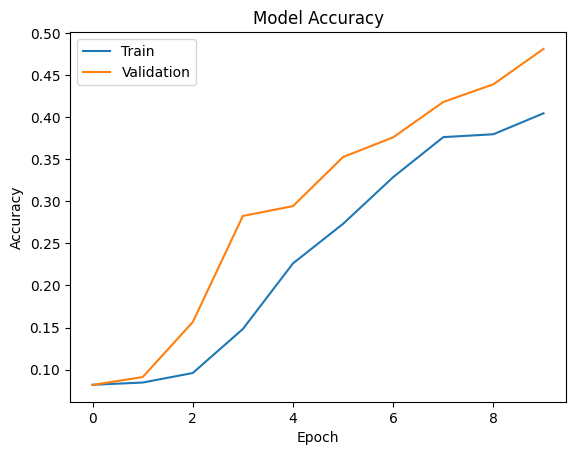

In [436]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [437]:
accuracy = new_model.evaluate(X_test_normalized, y_test_encoded, verbose=2)

15/15 - 2s - loss: 0.2106 - accuracy: 0.4989 - 2s/epoch - 117ms/step


In [438]:
# Here we would get the output as probablities for each category
y_pred=new_model.predict(X_test_normalized)

15/15 [==============================] - 1s 40ms/step


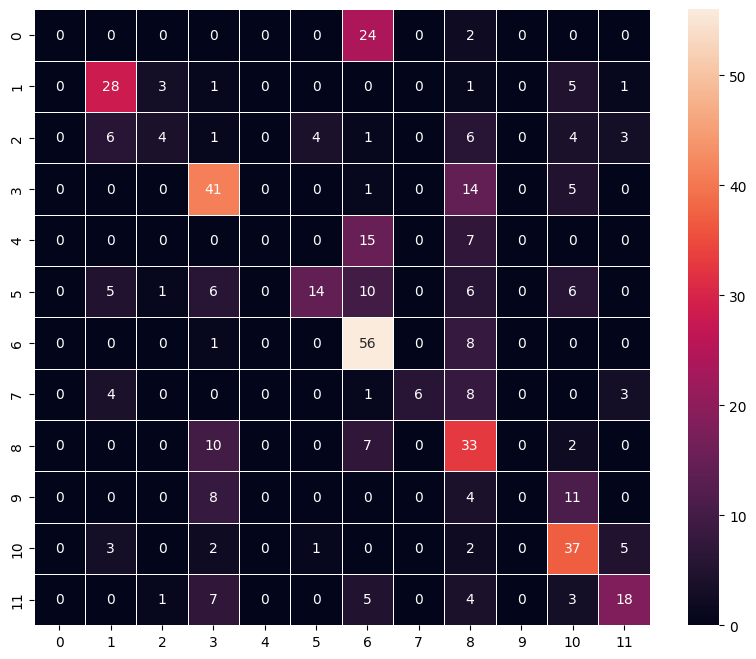

In [439]:
# Obtaining the categorical values from y_test_encoded and y_pred
y_pred_arg=np.argmax(y_pred,axis=1)
y_test_arg=np.argmax(y_test_encoded,axis=1)

# Plotting the Confusion Matrix using confusion matrix() function which is also predefined tensorflow module
confusion_matrix = tf.math.confusion_matrix(y_test_arg,y_pred_arg)
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(
    confusion_matrix,
    annot=True,
    linewidths=.4,
    fmt="d",
    square=True,
    ax=ax
)
plt.show()

## Final Model

In [447]:
images_decreased=[]
height = 64
width = 64
dimensions = (width, height)
for i in range(len(images)):
  images_decreased.append( cv2.resize(images[i], dimensions, interpolation=cv2.INTER_LINEAR))

In [448]:
from sklearn.model_selection import train_test_split
X_temp, X_test, y_temp, y_test = train_test_split(np.array(images_decreased),labels , test_size=0.1, random_state=42,stratify=labels)
X_train, X_val, y_train, y_val = train_test_split(X_temp,y_temp , test_size=0.1, random_state=42,stratify=y_temp)

In [449]:
print(X_train.shape,y_train.shape)
print(X_val.shape,y_val.shape)
print(X_test.shape,y_test.shape)

(3847, 64, 64, 3) (3847, 1)
(428, 64, 64, 3) (428, 1)
(475, 64, 64, 3) (475, 1)


In [450]:
# Convert labels from names to one hot vectors.
# We have already used encoding methods like onehotencoder and labelencoder earlier so now we will be using a new encoding method called labelBinarizer.
# Labelbinarizer works similar to onehotencoder

from sklearn.preprocessing import LabelBinarizer
enc = LabelBinarizer()
y_train_encoded = enc.fit_transform(y_train)
y_val_encoded=enc.transform(y_val)
y_test_encoded=enc.transform(y_test)

In [451]:
# Normalizing the image pixels
X_train_normalized = X_train.astype('float32')/255.0
X_val_normalized = X_val.astype('float32')/255.0
X_test_normalized = X_test.astype('float32')/255.0

In [452]:
# Intializing a sequential model
model = Sequential()

# Adding first conv layer with 64 filters and kernel size 3x3 , padding 'same' provides the output size same as the input size
# Input_shape denotes input image dimension images
model.add(Conv2D(64, (3, 3), activation='relu', padding="same", input_shape=(64, 64, 3)))

# Adding max pooling to reduce the size of output of first conv layer
model.add(MaxPooling2D((2, 2), padding = 'same'))
# model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu', padding="same"))
model.add(MaxPooling2D((2, 2), padding = 'same'))
model.add(BatchNormalization())

model.add(Conv2D(16, (3, 3), activation='relu', padding="same"))
model.add(MaxPooling2D((2, 2), padding = 'same'))
model.add(BatchNormalization())


# flattening the output of the conv layer after max pooling to make it ready for creating dense connections
model.add(Flatten())

# Adding a fully connected dense layer with 100 neurons
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.3))
# Adding the output layer with 10 neurons and activation functions as softmax since this is a multi-class classification problem
model.add(Dense(12, activation='softmax'))

# Using SGD Optimizer
# opt = SGD(learning_rate=0.01, momentum=0.9)
opt=Adam()
# Compile model
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Generating the summary of the model
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 64, 64, 64)        1792      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 32, 32, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 32, 32, 32)        18464     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 16, 16, 32)       0         
 g2D)                                                            
                                                                 
 batch_normalization_5 (Batc  (None, 16, 16, 32)       128       
 hNormalization)                                                 
                                                      

In [456]:
# Epochs
epochs = 30
# Batch size
batch_size = 32

history = model.fit(train_datagen.flow(X_train_normalized,y_train_encoded,
                                       batch_size=batch_size,
                                       seed=42,
                                       shuffle=False),
                    epochs=epochs,
                    steps_per_epoch=X_train_normalized.shape[0] // batch_size,
                    validation_data=(X_val_normalized,y_val_encoded),
                    verbose=1)

Epoch 1/30
120/120 [==============================] - 6s 49ms/step - loss: 0.7227 - accuracy: 0.7460 - val_loss: 0.9358 - val_accuracy: 0.7173
Epoch 2/30
120/120 [==============================] - 4s 34ms/step - loss: 0.6968 - accuracy: 0.7463 - val_loss: 1.3135 - val_accuracy: 0.6332
Epoch 3/30
120/120 [==============================] - 4s 33ms/step - loss: 0.6796 - accuracy: 0.7570 - val_loss: 0.8710 - val_accuracy: 0.7407
Epoch 4/30
120/120 [==============================] - 4s 35ms/step - loss: 0.6329 - accuracy: 0.7777 - val_loss: 0.9478 - val_accuracy: 0.7313
Epoch 5/30
120/120 [==============================] - 4s 33ms/step - loss: 0.6325 - accuracy: 0.7680 - val_loss: 1.2527 - val_accuracy: 0.6612
Epoch 6/30
120/120 [==============================] - 4s 36ms/step - loss: 0.6269 - accuracy: 0.7727 - val_loss: 0.8522 - val_accuracy: 0.7500
Epoch 7/30
120/120 [==============================] - 4s 35ms/step - loss: 0.5999 - accuracy: 0.7727 - val_loss: 0.8687 - val_accuracy: 0.7617

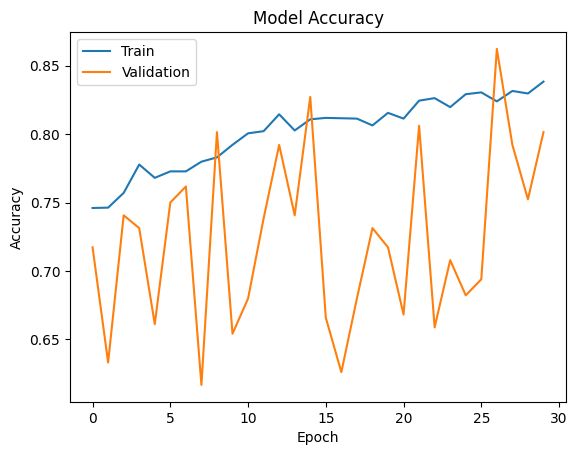

In [457]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [458]:
accuracy = model.evaluate(X_test_normalized, y_test_encoded, verbose=2)

15/15 - 0s - loss: 0.7642 - accuracy: 0.7516 - 57ms/epoch - 4ms/step


### Visualizing the prediction

In [ ]:
# Visualizing the predicted and correct label of images from test data
plt.figure(figsize=(2,2))
plt.imshow(X_test[2])
plt.show()
print('Predicted Label', enc.inverse_transform(new_model.predict((X_test_normalized[2].reshape(1,64,64,3)))))   # reshaping the input image as we are only trying to predict using a single image
print('True Label', enc.inverse_transform(y_test_encoded)[2])                                               # using inverse_transform() to get the output label from the output vector

plt.figure(figsize=(2,2))
plt.imshow(X_test[33])
plt.show()
print('Predicted Label', enc.inverse_transform(new_model.predict((X_test_normalized[33].reshape(1,64,64,3)))))  # reshaping the input image as we are only trying to predict using a single image
print('True Label', enc.inverse_transform(y_test_encoded)[33])                                              # using inverse_transform() to get the output label from the output vector

plt.figure(figsize=(2,2))
plt.imshow(X_test[36])
plt.show()
print('Predicted Label', enc.inverse_transform(new_model.predict((X_test_normalized[36].reshape(1,64,64,3)))))  # reshaping the input image as we are only trying to predict using a single image
print('True Label', enc.inverse_transform(y_test_encoded)[36])

## Actionable Insights and Business Recommendations

*

_____